### 4.1 Assertions Example

In [1]:
assert 2 + 2 == 4, 'The laws of mathematics are crumbling.'
# assert 2 + 2 == 5, 'You will see this message in an AssertionError.'

### 4.2 Position Class

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Dict, Callable, NewType, Any
from collections import OrderedDict, defaultdict

In [3]:
# load path
import sys
if "src/" not in sys.path:
    sys.path.append("src/")

from pypm import metrics, signals, data_io

In [4]:
Symbol = NewType('Symbol', str)
Dollars = NewType('Dollars', float)

DATE_FORMAT_STR = '%a %b %d, %Y'
def _pdate(date: pd.Timestamp):
    """Pretty-print a datetime with just the date"""
    return date.strftime(DATE_FORMAT_STR)

In [5]:
class Position(object):
    """
    A simple object to hold and manipulate data related to long stock trades.

    Allows a single buy and sell operation on an asset for a constant number of 
    shares.

    The __init__ method is equivelant to a buy operation. The exit
    method is a sell operation.
    """

    def __init__(self, symbol: Symbol, entry_date: pd.Timestamp, 
        entry_price: Dollars, shares: int):
        """
        Equivelent to buying a certain number of shares of the asset
        """

        # Recorded on initialization
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.shares = shares
        self.symbol = symbol

        # Recorded on position exit
        self.exit_date: pd.Timestamp = None
        self.exit_price: Dollars = None

        # For easily getting current portolio value
        self.last_date: pd.Timestamp = None
        self.last_price: Dollars = None

        # Updated intermediately
        self._dict_series: Dict[pd.Timestamp, Dollars] = OrderedDict()
        self.record_price_update(entry_date, entry_price)

        # Cache control for pd.Series representation
        self._price_series: pd.Series = None
        self._needs_update_pd_series: bool = True

    def exit(self, exit_date, exit_price):
        """
        Equivelent to selling a stock holding
        """
        assert self.entry_date != exit_date, 'Churned a position same-day.'
        assert not self.exit_date, 'Position already closed.'
        self.record_price_update(exit_date, exit_price)
        self.exit_date = exit_date
        self.exit_price = exit_price

    def record_price_update(self, date, price):
        """
        Stateless function to record intermediate prices of existing positions
        """
        self.last_date = date
        self.last_price = price
        self._dict_series[date] = price

        # Invalidate cache on self.price_series
        self._needs_update_pd_series = True

    @property
    def price_series(self) -> pd.Series:
        """
        Returns cached readonly pd.Series 
        """
        if self._needs_update_pd_series or self._price_series is None:
            self._price_series = pd.Series(self._dict_series)
            self._needs_update_pd_series = False
        return self._price_series

    @property
    def last_value(self) -> Dollars:
        return self.last_price * self.shares

    @property
    def is_active(self) -> bool:
        return self.exit_date is None

    @property
    def is_closed(self) -> bool:
        return not self.is_active
    
    @property
    def value_series(self) -> pd.Series:
        """
        Returns the value of the position over time. Ignores self.exit_date.
        Used in calculating the equity curve.
        """
        assert self.is_closed, 'Position must be closed to access this property'
        return self.shares * self.price_series[:-1]

    @property
    def percent_return(self) -> float:
        return (self.exit_price / self.entry_price) - 1
    
    @property
    def entry_value(self) -> Dollars:
        return self.shares * self.entry_price

    @property
    def exit_value(self) -> Dollars:
        return self.shares * self.exit_price

    @property
    def change_in_value(self) -> Dollars:
        return self.exit_value - self.entry_value

    @property
    def trade_length(self):
        return len(self._dict_series) - 1
    
    def print_position_summary(self):
        _entry_date = _pdate(self.entry_date)
        _exit_date = _pdate(self.exit_date)
        _days = self.trade_length

        _entry_price = round(self.entry_price, 2)
        _exit_price = round(self.exit_price, 2)

        _entry_value = round(self.entry_value, 2)
        _exit_value = round(self.exit_value, 2)

        _return = round(100 * self.percent_return, 1)
        _diff = round(self.change_in_value, 2)

        print(f'{self.symbol:<5}     Trade summary')
        print(f'Date:     {_entry_date} -> {_exit_date} [{_days} days]')
        print(f'Price:    ${_entry_price} -> ${_exit_price} [{_return}%]')
        print(f'Value:    ${_entry_value} -> ${_exit_value} [${_diff}]')
        print()

    def __hash__(self):
        """
        A unique position will be defined by a unique combination of an 
        entry_date and symbol, in accordance with our constraints regarding 
        duplicate, variable, and compound positions
        """
        return hash((self.entry_date, self.symbol))

### 4.3 Position Object Usage

In [6]:
import pandas as pd
from pypm import data_io, portfolio

In [7]:
symbol = 'AWU'
df = data_io.load_eod_data(symbol)
df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,193.94,191.70,190.63,195.51,968029
2010-01-05,191.02,188.17,186.99,192.42,1427075
2010-01-06,187.17,186.50,185.10,190.07,879014
2010-01-07,185.03,185.19,183.63,186.64,1003719
2010-01-08,184.67,187.02,182.78,187.27,804716


In [8]:
shares_to_buy = 50

In [9]:
for i, row in enumerate(df.itertuples()):
    date = row.Index
    price = row.close
    
    if i == 123:
        position = portfolio.Position(symbol, date, price, shares_to_buy)
    elif 123 < i < 234:
        position.record_price_update(date, price)
    elif i == 234:
        position.exit(date, price)

position.print_position_summary()

AWU       Trade summary
Date:     Wed Jun 30, 2010 -> Tue Dec 07, 2010 [111 days]
Price:    $220.34 -> $305.98 [38.9%]
Value:    $11017.0 -> $15299.0 [$4282.0]



### 4.4 Portfolio History Class

In [10]:
class PortfolioHistory(object):
    """
    Holds Position objects and keeps track of portfolio variables.
    Produces summary statistics.
    """

    def __init__(self):
        # Keep track of positions, recorded in this list after close
        self.position_history: List[Position] = []
        self._logged_positions: Set[Position] = set()

        # Keep track of the last seen date
        self.last_date: pd.Timestamp = pd.Timestamp.min

        # Readonly fields
        self._cash_history: Dict[pd.Timestamp, Dollars] = dict()
        self._simulation_finished = False
        self._spy: pd.DataFrame = pd.DataFrame()
        self._spy_log_returns: pd.Series = pd.Series(dtype='float64')

    def add_to_history(self, position: Position):
        _log = self._logged_positions
        assert not position in _log, 'Recorded the same position twice.'
        assert position.is_closed, 'Position is not closed.'
        self._logged_positions.add(position)
        self.position_history.append(position)
        self.last_date = max(self.last_date, position.last_date)

    def record_cash(self, date, cash):
        self._cash_history[date] = cash
        self.last_date = max(self.last_date, date)

    @staticmethod
    def _as_oseries(d: Dict[pd.Timestamp, Any]) -> pd.Series:
        return pd.Series(d).sort_index()

    def _compute_cash_series(self):
        self._cash_series = self._as_oseries(self._cash_history)

    @property
    def cash_series(self) -> pd.Series:
        return self._cash_series

    def _compute_portfolio_value_series(self):
        value_by_date = defaultdict(float)
        last_date = self.last_date

        # Add up value of assets
        for position in self.position_history:
            for date, value in position.value_series.items():
                value_by_date[date] += value

        # Make sure all dates in cash_series are present
        for date in self.cash_series.index:
            value_by_date[date] += 0

        self._portfolio_value_series = self._as_oseries(value_by_date)

    @property
    def portfolio_value_series(self):
        return self._portfolio_value_series

    def _compute_equity_series(self):
        c_series = self.cash_series
        p_series = self.portfolio_value_series
        assert all(c_series.index == p_series.index), \
            'portfolio_series has dates not in cash_series'
        self._equity_series = c_series + p_series     

    @property
    def equity_series(self):
        return self._equity_series

    def _compute_log_return_series(self):
        self._log_return_series = \
            metrics.calculate_log_return_series(self.equity_series)

    @property
    def log_return_series(self):
        return self._log_return_series

    def _assert_finished(self):
        assert self._simulation_finished, \
            'Simuation must be finished by running self.finish() in order ' + \
            'to access this method or property.'

    def finish(self):
        """
        Notate that the simulation is finished and compute readonly values
        """
        self._simulation_finished = True
        self._compute_cash_series()
        self._compute_portfolio_value_series()
        self._compute_equity_series()
        self._compute_log_return_series()
        self._assert_finished()

    def compute_portfolio_size_series(self) -> pd.Series:
        size_by_date = defaultdict(int)
        for position in self.position_history:
            for date in position.value_series.index:
                size_by_date[date] += 1
        return self._as_oseries(size_by_date)

    @property
    def spy(self):
        if self._spy.empty:
            self._spy = data_io.load_spy_data()
        return self._spy

    @property
    def spy_log_returns(self):
        if self._spy_log_returns.empty:
            close = self.spy['close']
            self._spy_log_returns =  metrics.calculate_log_return_series(close)
        return self._spy_log_returns

    @property
    def percent_return(self):
        return metrics.calculate_percent_return(self.equity_series)

    @property
    def spy_percent_return(self):
        return metrics.calculate_percent_return(self.spy['close'])

    @property
    def cagr(self):
        return metrics.calculate_cagr(self.equity_series)

    @property
    def volatility(self):
        return metrics.calculate_annualized_volatility(self.log_return_series)

    @property
    def sharpe_ratio(self):
        return metrics.calculate_sharpe_ratio(self.equity_series)

    @property
    def spy_cagr(self):
        return metrics.calculate_cagr(self.spy['close'])
    
    @property
    def excess_cagr(self):
        return self.cagr - self.spy_cagr

    @property
    def jensens_alpha(self):
        return metrics.calculate_jensens_alpha(
            self.log_return_series,
            self.spy_log_returns,
        )

    @property
    def dollar_max_drawdown(self):
        return metrics.calculate_max_drawdown(self.equity_series, 'dollar')

    @property
    def percent_max_drawdown(self):
        return metrics.calculate_max_drawdown(self.equity_series, 'percent')

    @property
    def log_max_drawdown_ratio(self):
        return metrics.calculate_log_max_drawdown_ratio(self.equity_series)
    
    @property
    def number_of_trades(self):
        return len(self.position_history)

    @property
    def average_active_trades(self):
        return self.compute_portfolio_size_series().mean()

    @property
    def final_cash(self):
        self._assert_finished()
        return self.cash_series[-1]
    
    @property
    def final_equity(self):
        self._assert_finished()
        return self.equity_series[-1]
    
    def print_position_summaries(self):
        for position in self.position_history:
            position.print_position_summary()

    def print_summary(self):
        self._assert_finished()
        s = f'Equity: ${self.final_equity:.2f}\n' \
            f'Percent Return: {100*self.percent_return:.2f}%\n' \
            f'S&P 500 Return: {100*self.spy_percent_return:.2f}%\n\n' \
            f'Number of trades: {self.number_of_trades}\n' \
            f'Average active trades: {self.average_active_trades:.2f}\n\n' \
            f'CAGR: {100*self.cagr:.2f}%\n' \
            f'S&P 500 CAGR: {100*self.spy_cagr:.2f}%\n' \
            f'Excess CAGR: {100*self.excess_cagr:.2f}%\n\n' \
            f'Annualized Volatility: {100*self.volatility:.2f}%\n' \
            f'Sharpe Ratio: {self.sharpe_ratio:.2f}\n' \
            f'Jensen\'s Alpha: {self.jensens_alpha:.6f}\n\n' \
            f'Dollar Max Drawdown: ${self.dollar_max_drawdown:.2f}\n' \
            f'Percent Max Drawdown: {100*self.percent_max_drawdown:.2f}%\n' \
            f'Log Max Drawdown Ratio: {self.log_max_drawdown_ratio:.2f}\n'

        print(s)

    def plot(self, show=True) -> plt.Figure:
        """
        Plots equity, cash and portfolio value curves.
        """
        self._assert_finished()

        figure, axes = plt.subplots(nrows=3, ncols=1)
        figure.tight_layout(pad=3.0)
        axes[0].plot(self.equity_series)
        axes[0].set_title('Equity')
        axes[0].grid()

        axes[1].plot(self.cash_series)
        axes[1].set_title('Cash')
        axes[1].grid()

        axes[2].plot(self.portfolio_value_series)
        axes[2].set_title('Portfolio Value')
        axes[2].grid()

        if show:
            plt.show()

        return figure

### 4.5 Portfolio History Usage

In [11]:
import pandas as pd
from pypm import data_io
from pypm.portfolio import Position, PortfolioHistory

In [12]:
symbol = 'AWU'
df = data_io.load_eod_data(symbol)
df.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,193.94,191.70,190.63,195.51,968029
2010-01-05,191.02,188.17,186.99,192.42,1427075
2010-01-06,187.17,186.50,185.10,190.07,879014
2010-01-07,185.03,185.19,183.63,186.64,1003719
2010-01-08,184.67,187.02,182.78,187.27,804716


In [13]:
portfolio_history = PortfolioHistory()
initial_cash = cash = 10000

In [14]:
for i, row in enumerate(df.itertuples()):
    date = row.Index
    price = row.close

    if i == 123:
        # Figure out how many shares to buy
        shares_to_buy = initial_cash / price 

        # Record the position
        position = Position(symbol, date, price, shares_to_buy)

        # Spend all of your cash
        cash -= initial_cash

    elif 123 < i < 2345:
        position.record_price_update(date, price)

    elif i == 2345:
        # Sell the asset
        position.exit(date, price)

        # Get your cash back
        cash += price * shares_to_buy

        # Record the position
        portfolio_history.add_to_history(position)

    # Record cash at every step
    portfolio_history.record_cash(date, cash)

portfolio_history.finish()

In [15]:
portfolio_history.print_position_summaries()

AWU       Trade summary
Date:     Wed Jun 30, 2010 -> Tue Apr 30, 2019 [2222 days]
Price:    $220.34 -> $386.26 [75.3%]
Value:    $10000.0 -> $17530.18 [$7530.18]



In [16]:
portfolio_history.print_summary()

Equity: $17530.18
Percent Return: 75.30%
S&P 500 Return: 183.25%

Number of trades: 1
Average active trades: 1.00

CAGR: 5.78%
S&P 500 CAGR: 10.99%
Excess CAGR: -5.21%

Annualized Volatility: 29.97%
Sharpe Ratio: 0.19
Jensen's Alpha: -0.000197

Dollar Max Drawdown: $9006.08
Percent Max Drawdown: 60.08%
Log Max Drawdown Ratio: -0.36



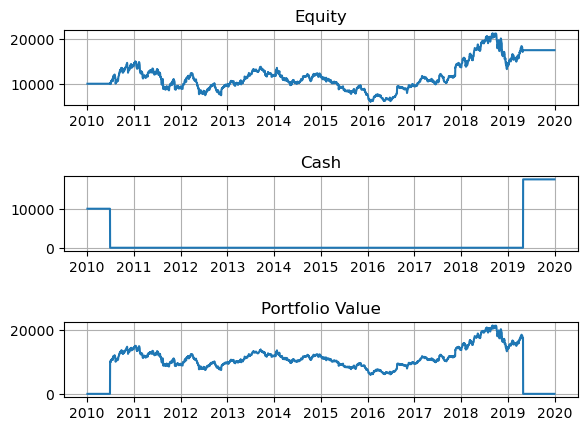

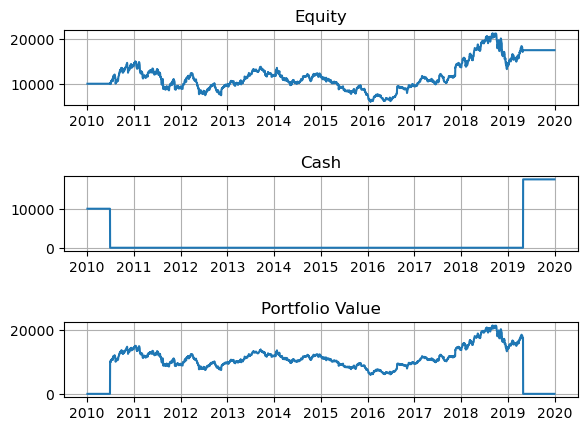

In [17]:
portfolio_history.plot()

### 4.6 Simple Simulator Class

In [18]:
from typing import Tuple, List, Dict, Callable, NewType, Any, Iterable
import pandas as pd
import matplotlib.pyplot as plt
from pypm import metrics, signals, data_io
from pypm.portfolio import PortfolioHistory, Position, Symbol, Dollars
from collections import OrderedDict, defaultdict

In [19]:
class SimpleSimulator(object):
    """
    A simple trading simulator to work with the PortfolioHistory class
    """

    def __init__(self, initial_cash: float=10000, max_active_positions: int=5,
        percent_slippage: float=0.0005, trade_fee: float=1):

        ### Set simulation parameters

        # Initial cash in porfolio
        # self.cash will fluctuate
        self.initial_cash = self.cash = initial_cash

        # Maximum number of different assets that can be help simultaneously
        self.max_active_positions: int = max_active_positions

        # The percentage difference between closing price and fill price for the
        # position, to simulate adverse effects of market orders
        self.percent_slippage = percent_slippage

        # The fixed fee in order to open a position in dollar terms
        self.trade_fee = trade_fee

        # Keep track of live trades
        self.active_positions_by_symbol: Dict[Symbol, Position] = OrderedDict()

        # Keep track of portfolio history like cash, equity, and positions
        self.portfolio_history = PortfolioHistory()

    @property
    def active_positions_count(self):
        return len(self.active_positions_by_symbol)

    @property
    def free_position_slots(self):
        return self.max_active_positions - self.active_positions_count

    @property
    def active_symbols(self) -> List[Symbol]:
        return list(self.active_positions_by_symbol.keys())

    def print_initial_parameters(self):
        s = f'Initial Cash: ${self.initial_cash} \n' \
            f'Maximum Number of Assets: {self.max_active_positions}\n'
        print(s)
        return s

    @staticmethod
    def make_tuple_lookup(columns) -> Callable[[str, str], int]:
        """
        Map a multi-index dataframe to an itertuples-like object.

        The index of the dateframe is always the zero-th element.
        """

        # col is a hierarchical column index represented by a tuple of strings
        tuple_lookup: Dict[Tuple[str, str], int] = { 
            col: i + 1 for i, col in enumerate(columns) 
        }

        return lambda symbol, metric: tuple_lookup[(symbol, metric)]

    @staticmethod
    def make_all_valid_lookup(_idx: Callable):
        """
        Return a function that checks for valid data, given a lookup function
        """
        return lambda row, symbol: (
            not pd.isna(row[_idx(symbol, 'pref')]) and \
            not pd.isna(row[_idx(symbol, 'signal')]) and \
            not pd.isna(row[_idx(symbol, 'price')])
        )

    def buy_to_open(self, symbol, date, price):
        """
        Keep track of new position, make sure it isn't an existing position. 
        Verify you have cash.
        """

        # Figure out how much we are willing to spend
        cash_to_spend = self.cash / self.free_position_slots
        cash_to_spend -= self.trade_fee

        # Calculate buy_price and number of shares. Fractional shares allowed.
        purchase_price = (1 + self.percent_slippage) * price
        shares = cash_to_spend / purchase_price

        # Spend the cash
        self.cash -= cash_to_spend + self.trade_fee
        assert self.cash >= 0, 'Spent cash you do not have.'
        self.portfolio_history.record_cash(date, self.cash)   

        # Record the position
        positions_by_symbol = self.active_positions_by_symbol
        assert not symbol in positions_by_symbol, 'Symbol already in portfolio.'        
        position = Position(symbol, date, purchase_price, shares)
        positions_by_symbol[symbol] = position

    def sell_to_close(self, symbol, date, price):
        """
        Keep track of exit price, recover cash, close position, and record it in
        portfolio history.

        Will raise a KeyError if symbol isn't an active position
        """

        # Exit the position
        positions_by_symbol = self.active_positions_by_symbol
        position = positions_by_symbol[symbol]
        position.exit(date, price)

        # Receive the cash
        sale_value = position.last_value * (1 - self.percent_slippage)
        self.cash += sale_value
        self.portfolio_history.record_cash(date, self.cash)

        # Record in portfolio history
        self.portfolio_history.add_to_history(position)
        del positions_by_symbol[symbol]
    
    @staticmethod
    def _assert_equal_columns(*args: Iterable[pd.DataFrame]):
        column_names = set(args[0].columns.values)
        for arg in args[1:]:
            assert set(arg.columns.values) == column_names, \
                'Found unequal column names in input data frames.'

    def simulate(self, price: pd.DataFrame, signal: pd.DataFrame, 
        preference: pd.DataFrame):
        """
        Runs the simulation.

        price, signal, and preference are data frames with the column names 
        represented by the same set of stock symbols.
        """

        # Create a hierarchical data frame to loop through
        self._assert_equal_columns(price, signal, preference)
        df = data_io.concatenate_metrics({
            'price': price,
            'signal': signal,
            'pref': preference,
        })

        # Get list of symbols
        all_symbols = list(set(price.columns.values))

        # Get lookup functions
        _idx = self.make_tuple_lookup(df.columns)
        _all_valid = self.make_all_valid_lookup(_idx)

        # Store some variables
        active_positions_by_symbol = self.active_positions_by_symbol
        max_active_positions = self.max_active_positions

        # Iterating over all dates.
        # itertuples() is significantly faster than iterrows(), it however comes
        # at the cost of being able index easily. In order to get around this
        # we use an tuple lookup function: "_idx"
        for row in df.itertuples():

            # date index is always first element of tuple row
            date = row[0]

            # Get symbols with valid and tradable data
            symbols: List[str] = [s for s in all_symbols if _all_valid(row, s)]

            # Iterate over active positions and sell stocks with a sell signal.
            _active = self.active_symbols
            to_exit = [s for s in _active if row[_idx(s, 'signal')] == -1]
            for s in to_exit:
                sell_price = row[_idx(s, 'price')]
                self.sell_to_close(s, date, sell_price)

            # Get up to max_active_positions symbols with a buy signal in 
            # decreasing order of preference
            to_buy = [
                s for s in symbols if \
                    row[_idx(s, 'signal')] == 1 and \
                    not s in active_positions_by_symbol
            ]
            to_buy.sort(key=lambda s: row[_idx(s, 'pref')], reverse=True)
            to_buy = to_buy[:max_active_positions]

            for s in to_buy:
                buy_price = row[_idx(s, 'price')]
                buy_preference = row[_idx(s, 'pref')]

                # If we have some empty slots, just buy the asset outright
                if self.active_positions_count < max_active_positions:
                    self.buy_to_open(s, date, buy_price)
                    continue

                # If are holding max_active_positions, evaluate a swap based on
                # preference
                _active = self.active_symbols
                active_prefs = [(s, row[_idx(s, 'pref')]) for s in _active]

                _min = min(active_prefs, key=lambda k: k[1])
                min_active_symbol, min_active_preference = _min

                # If a more preferable symbol exists, then sell an old one
                if min_active_preference < buy_preference:
                    sell_price = row[_idx(min_active_symbol, 'price')]
                    self.sell_to_close(min_active_symbol, date, sell_price)
                    self.buy_to_open(s, date, buy_price)

            # Update price data everywhere
            for s in self.active_symbols:
                price = row[_idx(s, 'price')]
                position = active_positions_by_symbol[s]
                position.record_price_update(date, price)

        # Sell all positions and mark simulation as complete
        for s in self.active_symbols:
            self.sell_to_close(s, date, row[_idx(s, 'price')])
        self.portfolio_history.finish()

### 4.7 Simple Simulator Usage

In [20]:
from pypm import metrics, signals, data_io, simulation
import pandas as pd

MTZB      Trade summary
Date:     Wed Feb 03, 2010 -> Thu Feb 04, 2010 [1 days]
Price:    $83.77 -> $80.94 [-3.4%]
Value:    $1999.55 -> $1931.96 [$-67.59]

VHE       Trade summary
Date:     Wed Feb 03, 2010 -> Thu Feb 04, 2010 [1 days]
Price:    $155.6 -> $151.04 [-2.9%]
Value:    $1999.8 -> $1941.22 [$-58.58]

PQCE      Trade summary
Date:     Thu Feb 04, 2010 -> Fri Feb 05, 2010 [1 days]
Price:    $161.2 -> $159.01 [-1.4%]
Value:    $1929.99 -> $1903.76 [$-26.23]

XJJI      Trade summary
Date:     Fri Feb 05, 2010 -> Mon Feb 08, 2010 [1 days]
Price:    $87.81 -> $86.93 [-1.0%]
Value:    $1901.81 -> $1882.67 [$-19.14]

BMG       Trade summary
Date:     Mon Feb 08, 2010 -> Tue Feb 16, 2010 [5 days]
Price:    $57.88 -> $63.81 [10.2%]
Value:    $1880.73 -> $2073.45 [$192.73]

XSOQ      Trade summary
Date:     Tue Feb 16, 2010 -> Tue Feb 23, 2010 [5 days]
Price:    $77.1 -> $77.29 [0.2%]
Value:    $2071.42 -> $2076.56 [$5.14]

TRE       Trade summary
Date:     Thu Feb 04, 2010 -> Fri Mar

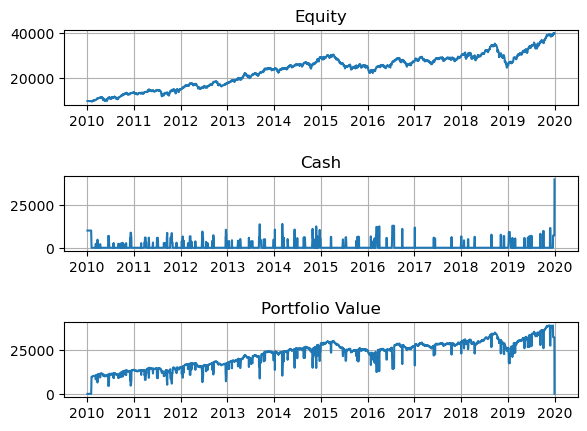

In [21]:
def simulate_portfolio():

    bollinger_n = 20
    sharpe_n = 20

    # Load in data
    symbols: List[str] = data_io.get_all_symbols()
    prices: pd.DataFrame = data_io.load_eod_matrix(symbols)

    # Use the bollinger band outer band crossorver as a signal
    _bollinger = signals.create_bollinger_band_signal
    signal = prices.apply(_bollinger, args=(bollinger_n,), axis=0)

    # Use a rolling sharpe ratio approximation as a preference matrix
    _sharpe = metrics.calculate_rolling_sharpe_ratio
    preference = prices.apply(_sharpe, args=(sharpe_n, ), axis=0)

    # Run the simulator
    simulator = simulation.SimpleSimulator(
        initial_cash=10000,
        max_active_positions=5,
        percent_slippage=0.0005,
        trade_fee=1,
    )
    simulator.simulate(prices, signal, preference)

    # Print results
    simulator.portfolio_history.print_position_summaries()
    simulator.print_initial_parameters()
    simulator.portfolio_history.print_summary()
    simulator.portfolio_history.plot()

simulate_portfolio()